In [85]:
from zipfile import ZipFile

with ZipFile("drive/My Drive/Project-OCR/datasets/Data_ctc.zip", "r") as zip_:
    zip_.extractall()
    print("Extracted all")

Extracted all


In [86]:
! rm -r Data_ctc/crop_m4/

In [87]:
import os
import cv2
import math
import numpy as np
from matplotlib import pyplot
from collections import defaultdict
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Reshape, Dense, Conv2D, MaxPooling2D, LSTM, Activation, add , concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

In [88]:
np.random.seed(42)

In [89]:
! mkdir images

mkdir: cannot create directory ‘images’: File exists


In [90]:
images = []
w, h = 256, 80
image_names = defaultdict(int)

for dir_ in os.listdir("Data_ctc/"):
    for img_name in os.listdir(os.path.join("Data_ctc", dir_)):
        img = cv2.imread(os.path.join("Data_ctc", dir_, img_name))
        img = cv2.resize(img, (w, h))
        image_names[img_name] += 1
        img_name = str(image_names[img_name]) + "_" + img_name
        cv2.imwrite(f"images/{img_name}", img)
        images.append(img)

images = np.array(images)
images.shape

(520, 80, 256, 3)

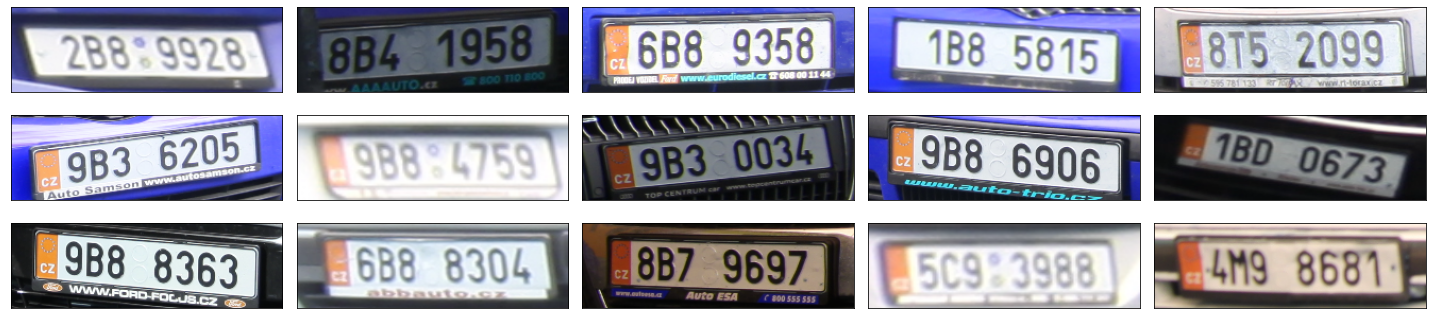

In [91]:
img_indices = np.random.randint(0, images.shape[0], 15)
pyplot.figure(1, (20, 5))

for plot_idx,img_idx in enumerate(img_indices):
    ax = pyplot.subplot(3,5,plot_idx+1)
    ax.imshow(images[img_idx])
    ax.set_xticks([])
    ax.set_yticks([])
    pyplot.tight_layout()

In [92]:
! mkdir images_pp

mkdir: cannot create directory ‘images_pp’: File exists


In [93]:
psf = np.ones((5,5)) / 25
custom_kernel = np.array(
    [[0,0,-1,0,0],
    [0,-2,-3,-2,0],
    [-1,-3,25,-3,-1],
    [0,-2,-3,-2,0],
    [0,0,-1,0,0]]
)
morph_kernel = np.ones((3,3), np.uint8)
images = []
images_text = []

for img_name in os.listdir("images/"):
    img_stage0 = cv2.imread("images/"+img_name, cv2.IMREAD_GRAYSCALE)

    img_stage1 = cv2.GaussianBlur(img_stage0, (5,5),0)
    
    img_stage2 = img_stage1.copy()
    lap = cv2.Laplacian(img_stage2, cv2.CV_64F).var()
    if lap < 250:
        img_stage2 = cv2.filter2D(img_stage2, -1, custom_kernel)
    
    _, img_stage3 = cv2.threshold(img_stage2, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    img_stage4 = cv2.morphologyEx(img_stage3, cv2.MORPH_CLOSE, morph_kernel) # first dilate than erode
    img_stage4 = cv2.bitwise_not(img_stage4)

    img_text = img_name.split("_")[1]
    img_text = img_text.split(".")[0]
    # img_text = img_text.replace(" ", "")
    img_text = img_text.replace("-", "")
    if len(img_text) != 8:
        continue

    images_text.append(img_text)
    cv2.imwrite(f"images_pp/{img_name}", img_stage4)
    img_stage4 = np.expand_dims(img_stage4, axis=2)
    images.append(img_stage4)


images = np.array(images)
images.shape, len(images_text)

((514, 80, 256, 1), 514)

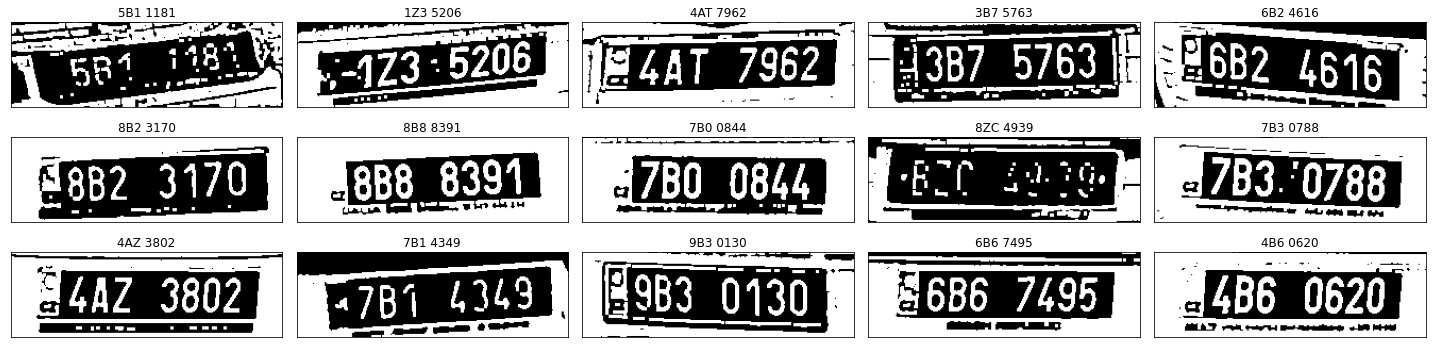

In [94]:
img_indices = np.random.randint(0, images.shape[0], 15)
pyplot.figure(1, (20, 5))

for plot_idx,img_idx in enumerate(img_indices):
    ax = pyplot.subplot(3,5,plot_idx+1)
    ax.imshow(images[img_idx, :, :, 0], cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(images_text[img_idx])
    pyplot.tight_layout()

In [95]:
unique_tokens = 38 # 26alpha 10nums 1space 1blank

In [96]:
images_norm = images.astype("float32") / 255.

In [97]:
token_to_num = defaultdict(int)

alphabets = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 "
count = 0
for token in alphabets:
    token_to_num[token] = count
    count += 1

count

37

In [98]:
num_to_token = {v:k for k,v in token_to_num.items()}

In [99]:
def text_2_label(text):
    label = []
    for token in text.upper():
        label.append(token_to_num[token])
    return label

def label_2_text(labels):
    text = ""
    for label in labels:
        if label == len(alphabets):  # CTC Blank
            text.append("")
        else:
            text += num_to_token[label]
    return text

In [100]:
labels = list(map(text_2_label, images_text))
labels = np.array(labels)
labels.shape

(514, 8)

In [101]:
images_text[0], labels[0]

('2Z5 2689', array([28, 25, 31, 36, 28, 32, 34, 35]))

In [102]:
LABEL_LEN = 8
label_length = [LABEL_LEN] * len(images_text)
label_length = np.array(label_length)
label_length.shape

(514,)

In [103]:
input_length = [256 // 4 - 2] * len(images_text)
input_length = np.array(input_length)
input_length.shape

(514,)

In [104]:
img_train, img_test, labels_train, labels_test, label_length_train, label_length_test, input_length_train, input_length_test = \
train_test_split(images_norm, labels, label_length, input_length, train_size=0.8, shuffle=True, random_state=42)

img_train.shape, img_test.shape

((411, 80, 256, 1), (103, 80, 256, 1))

In [105]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    
    # the 2 is critical here since the first couple outputs of the RNN tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

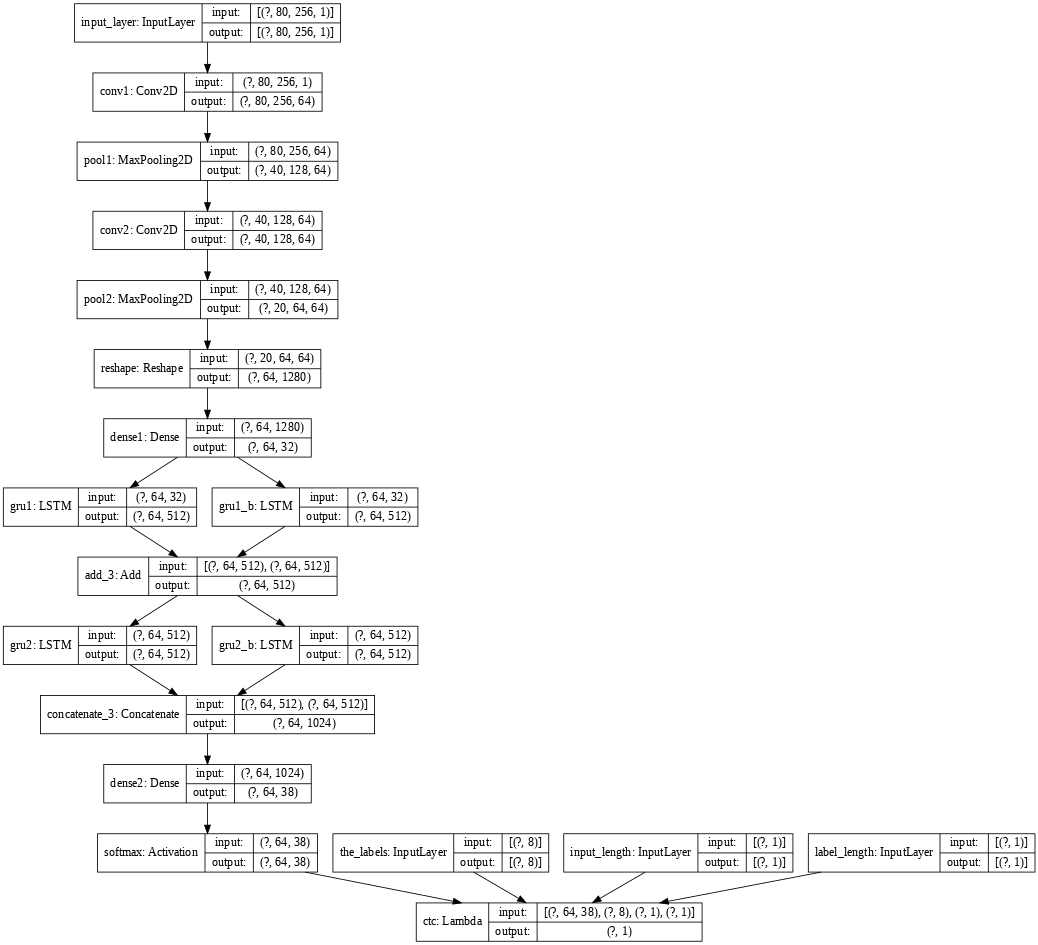

In [106]:
shape_in = images.shape[1:]
shape_out = unique_tokens
filters=64
pool_size=2

model_in = Input(shape=shape_in, name='input_layer')

X = Conv2D(
    filters=filters,
    kernel_size=(3,3),
    padding='same',
    activation="relu",
    kernel_initializer='he_normal',
    name='conv1')(model_in)
X = MaxPooling2D(pool_size=(pool_size, pool_size), name='pool1')(X)

X = Conv2D(
    filters=filters,
    kernel_size=(3,3),
    padding='same',
    activation="relu",
    kernel_initializer='he_normal',
    name='conv2')(X)
X = MaxPooling2D(pool_size=(pool_size, pool_size), name='pool2')(X)

img_h, img_w = shape_in[:2]
conv_to_rnn_dims = (img_w // (pool_size ** 2), (img_h // (pool_size ** 2)) * filters)
X = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(X)

X = Dense(
    units=32,
    activation="relu",
    name='dense1')(X)

gru_1 = LSTM(
    units=512,
    return_sequences=True,
    kernel_initializer='he_normal',
    name='gru1')(X)
gru_1b = LSTM(
    units=512,
    return_sequences=True,
    go_backwards=True,
    kernel_initializer='he_normal',
    name='gru1_b')(X)
X = add([gru_1, gru_1b])

gru_2 = LSTM(
    units=512,
    return_sequences=True,
    kernel_initializer='he_normal',
    name='gru2')(X)
gru_2b = LSTM(
    units=512,
    return_sequences=True,
    go_backwards=True,
    kernel_initializer='he_normal',
    name='gru2_b')(X)
X = concatenate([gru_2, gru_2b])

X = Dense(
    units=shape_out,
    kernel_initializer='he_normal',
    name='dense2')(X)

y_pred_layer = Activation('softmax', name='softmax')(X)
label_layer = Input(name='the_labels', shape=[LABEL_LEN], dtype='float32')
input_length_layer = Input(name='input_length', shape=[1], dtype='int64')
label_length_layer = Input(name='label_length', shape=[1], dtype='int64')

model_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred_layer, label_layer, input_length_layer, label_length_layer])
model = Model(inputs=[model_in, label_layer, input_length_layer, label_length_layer], outputs=model_out, name="OCR_CTC")

plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=60)

In [107]:
optim = tf.keras.optimizers.Adam(lr=0.001)

model.compile(
    loss={'ctc': lambda y_true, y_pred: y_pred},
    optimizer=optim,
)

history = model.fit(
    x = [img_train, labels_train, input_length_train, label_length_train],
    y = labels_train,
    batch_size = 64,
    epochs = 150,
)

Epoch 1/150
7/7 [==============================] - 1s 111ms/step - loss: 63.1934
Epoch 2/150
7/7 [==============================] - 1s 90ms/step - loss: 24.9657
Epoch 3/150
7/7 [==============================] - 1s 90ms/step - loss: 22.9844
Epoch 4/150
7/7 [==============================] - 1s 91ms/step - loss: 22.3420
Epoch 5/150
7/7 [==============================] - 1s 90ms/step - loss: 21.7622
Epoch 6/150
7/7 [==============================] - 1s 90ms/step - loss: 21.2916
Epoch 7/150
7/7 [==============================] - 1s 90ms/step - loss: 20.8377
Epoch 8/150
7/7 [==============================] - 1s 94ms/step - loss: 20.5459
Epoch 9/150
7/7 [==============================] - 1s 93ms/step - loss: 20.2440
Epoch 10/150
7/7 [==============================] - 1s 91ms/step - loss: 19.9421
Epoch 11/150
7/7 [==============================] - 1s 90ms/step - loss: 19.5613
Epoch 12/150
7/7 [==============================] - 1s 92ms/step - loss: 19.2591
Epoch 13/150
7/7 [==================

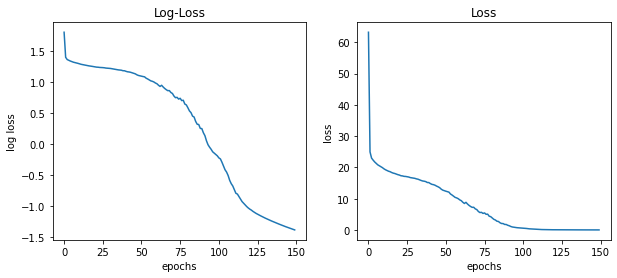

In [108]:
pyplot.figure(1, (10, 4))

ax = pyplot.subplot(1,2,1)
ax.plot(history.epoch, np.log10(history.history["loss"]), label="train")
ax.set_xlabel("epochs")
ax.set_ylabel("log loss")
pyplot.title("Log-Loss")

ax = pyplot.subplot(1,2,2)
ax.plot(history.epoch, history.history["loss"], label="train")
ax.set_xlabel("epochs")
ax.set_ylabel("loss")
pyplot.title("Loss")

pyplot.show()

In [109]:
model_p = Model(inputs=model_in, outputs=y_pred_layer)

In [110]:
def decode_predict_ctc(out, top_paths = 1):
    results = []
    beam_width = 5
    if beam_width < top_paths:
      beam_width = top_paths
    for i in range(top_paths):
      lables = K.get_value(K.ctc_decode(out, input_length=np.ones(out.shape[0])*out.shape[1],
                           greedy=False, beam_width=beam_width, top_paths=top_paths)[0][i])[0]
      text = label_2_text(lables)
      results.append(text)
    return results
  
def predit_a_image(a, top_paths = 1):
  c = np.expand_dims(a.T, axis=0)
  net_out_value = model_p.predict(c)
  top_pred_texts = decode_predict_ctc(net_out_value, top_paths)
  return top_pred_texts


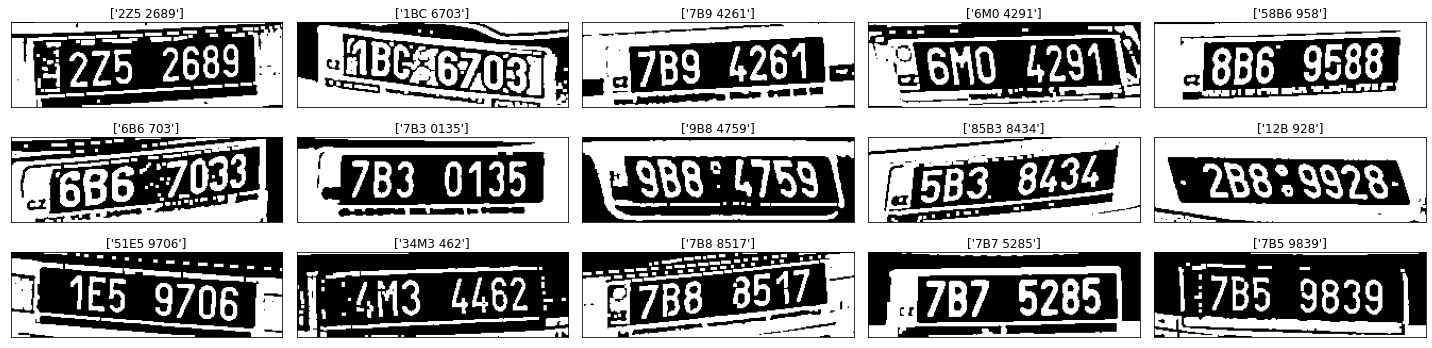

In [111]:
img_indices = np.random.randint(0, img_train.shape[0], 15)
pyplot.figure(1, (20, 5))

for plot_idx,img_idx in enumerate(img_indices):
    ax = pyplot.subplot(3,5,plot_idx+1)
    
    ax.imshow(img_train[img_idx, :, :, 0], cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])

    c = np.expand_dims(img_train[img_idx], axis=0)
    net_out_value = model_p.predict(c)
    pred_text = decode_predict_ctc(net_out_value)
    
    ax.set_title(pred_text)
    pyplot.tight_layout()

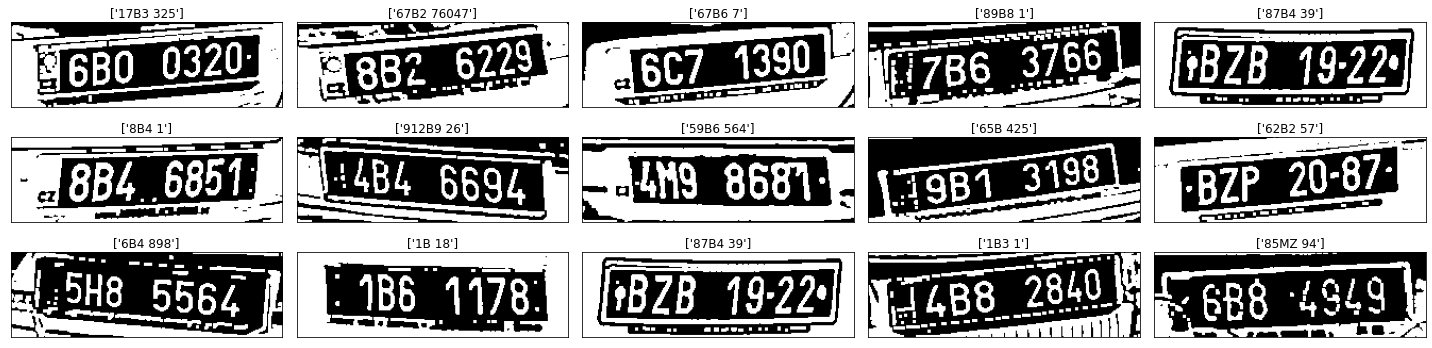

In [112]:
img_indices = np.random.randint(0, img_test.shape[0], 15)
pyplot.figure(1, (20, 5))

for plot_idx,img_idx in enumerate(img_indices):
    ax = pyplot.subplot(3,5,plot_idx+1)
    
    ax.imshow(img_test[img_idx, :, :, 0], cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])

    c = np.expand_dims(img_test[img_idx], axis=0)
    net_out_value = model_p.predict(c)
    pred_text = decode_predict_ctc(net_out_value)
    
    ax.set_title(pred_text)
    pyplot.tight_layout()